In [1]:
# !pip install hdbscan
# !pip install umap-learn

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import BertTokenizer, BertModel
from hdbscan import HDBSCAN

from sklearn import metrics
import umap

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## TF-IDF Vectorization on the Utterance Level

In [4]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000,
                                   min_df=1,
                                   max_df=0.85,
                                   ngram_range=(1, 2))

In [5]:
X_tfidf = tfidf_vectorizer.fit_transform(test['text'])

In [6]:
X_tfidf.shape

(3080, 1000)

In [7]:
tfidf_matrix=X_tfidf.toarray()

## UMAP Dimension Reduction

In [8]:
umap_model = umap.UMAP(n_neighbors=10,n_components=5, metric='cosine')
umap_reduced = umap_model.fit_transform(tfidf_matrix)

## HDBSCAN Clustering with UMAP and TF-IDF on the Utterance Level

In [9]:
hdbscan_model = HDBSCAN(min_cluster_size=15)
clusters = hdbscan_model.fit_predict(umap_reduced)

test['topic'] = clusters

In [10]:
test['topic'].unique()

array([18, -1, 39,  3, 36, 26, 37, 11, 20, 14, 35,  9, 10, 31, 22,  8,  7,
       16,  2, 33, 28, 32, 13, 41, 29, 15, 27, 24, 23, 25, 42, 34, 30,  1,
       17,  4, 40, 43, 19,  6, 12, 21, 38,  0,  5])

<ipython-input-11-3701307bba0e>:8: UserWarning: 
The palette list has fewer values (33) than needed (45) and will cycle, which may produce an uninterpretable plot.
  scatter = sns.scatterplot(x=umap_reduced[:, 0], y=umap_reduced[:, 1],hue=test['topic'],legend='full', alpha=0.8,palette=custom_palette)


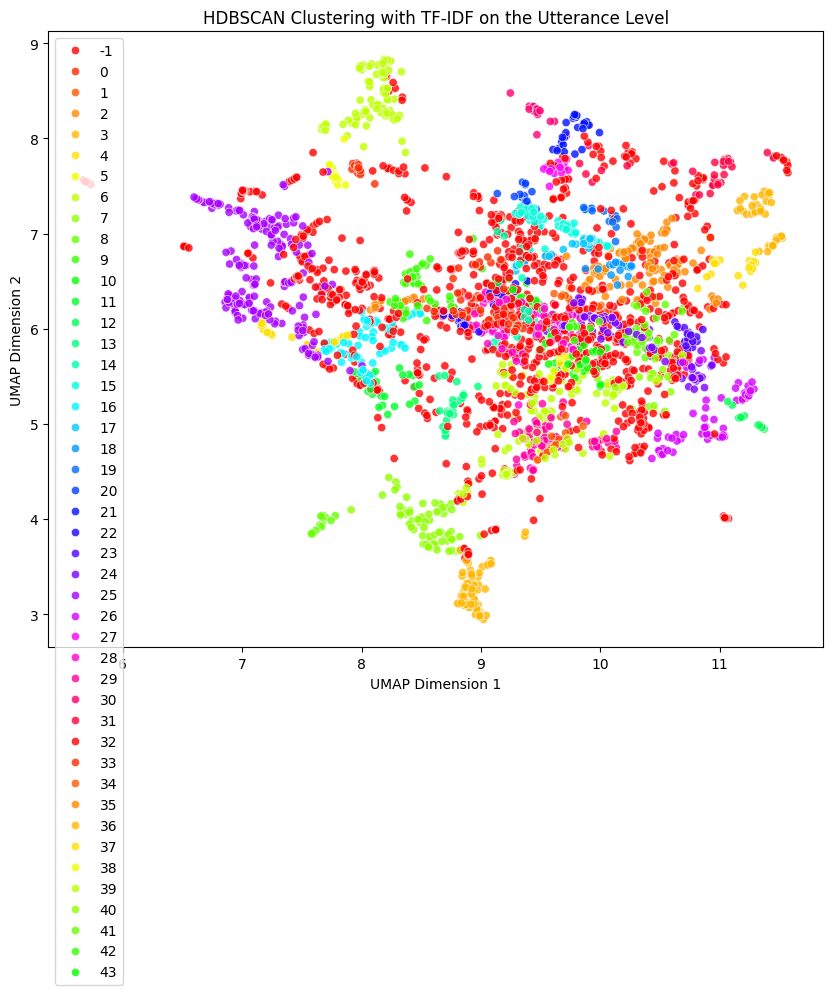

In [11]:
hues = np.linspace(0, 1, 33, endpoint=False)
saturation = 0.9
value = 0.9

custom_palette = [plt.cm.hsv(h) for h in hues]

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=umap_reduced[:, 0], y=umap_reduced[:, 1],hue=test['topic'],legend='full', alpha=0.8,palette=custom_palette)
plt.title('HDBSCAN Clustering with TF-IDF on the Utterance Level')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

## Bert-Banking Embedding on the Utterance Level

In [12]:
tokenizer = BertTokenizer.from_pretrained('philschmid/BERT-Banking77')
model = BertModel.from_pretrained('philschmid/BERT-Banking77')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
def get_sentence_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings

# Apply the function to each utterance
test['BERT_embeddings'] = test['text'].apply(get_sentence_embeddings)

## UMAP Dimension Reduction

In [14]:
bert_embeddings = np.vstack(test['BERT_embeddings'].to_numpy())
umap_embeddings = umap.UMAP(n_neighbors=10, n_components=5, metric='cosine').fit_transform(bert_embeddings)

## HDBSCAN Clustering with UMAP and Bert-Banking Embedding on the Utterance Level

In [18]:
hdbscan = HDBSCAN(min_cluster_size=18)
test["topic"] = hdbscan.fit_predict(umap_embeddings)

<ipython-input-19-a69b479b524f>:12: UserWarning: 
The palette list has fewer values (25) than needed (79) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=test["topic"], legend='full', alpha=0.8, palette=custom_palette)


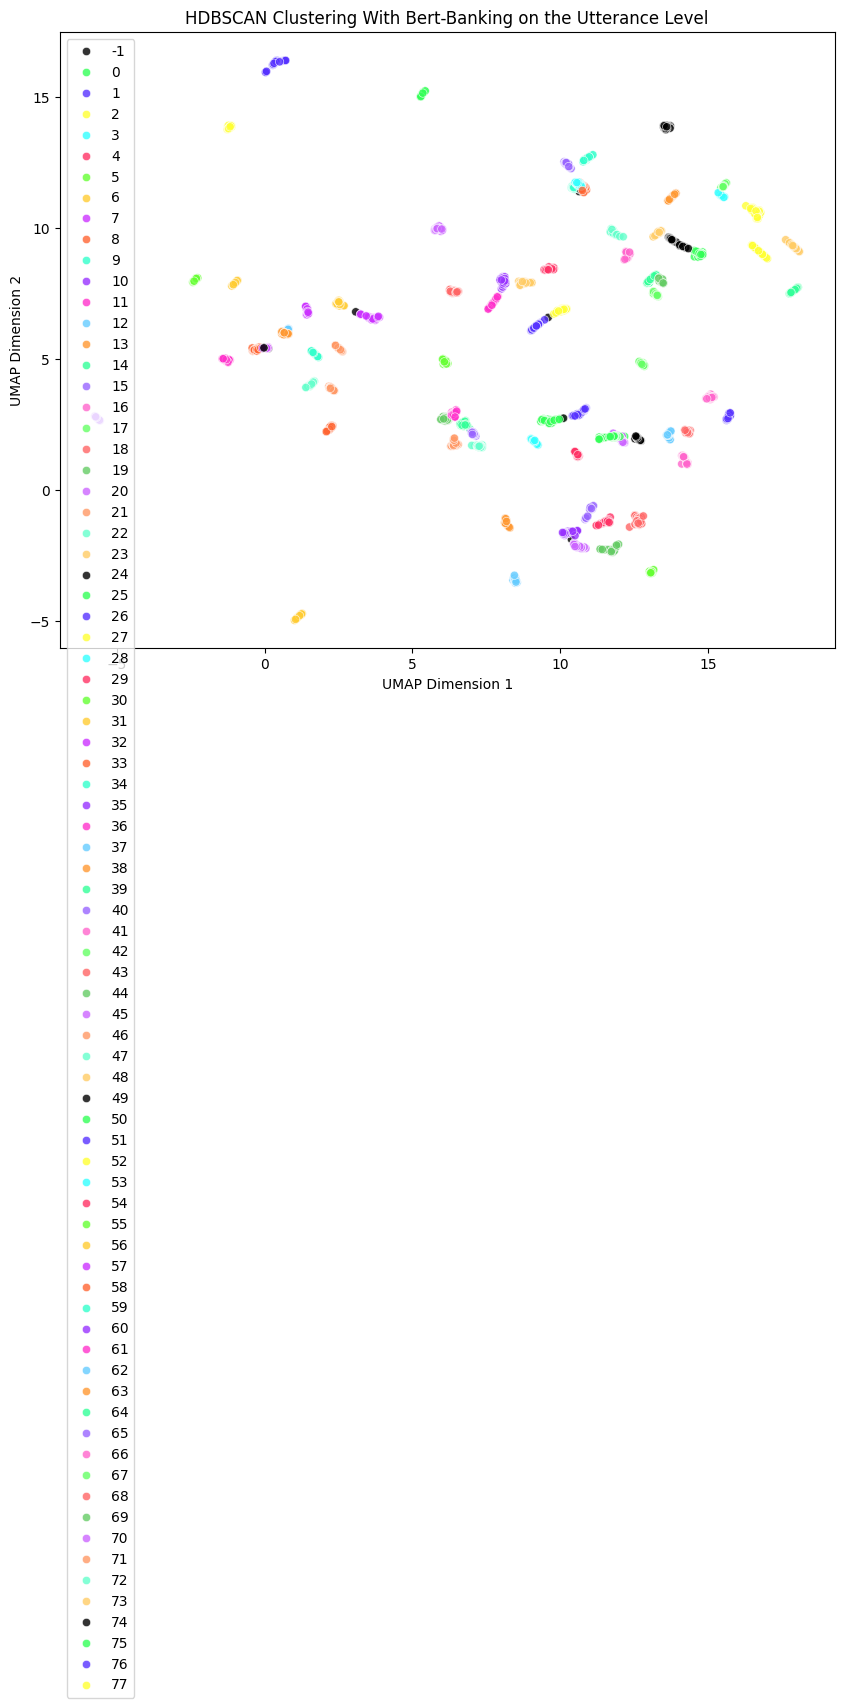

In [19]:
custom_colors = [
    '#000000', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF',
    '#FF3366', '#66FF33', '#FFCC33', '#CC33FF',
    '#FF6633', '#33FFCC', '#9933FF', '#FF33CC', '#66CCFF',
    '#FF9933', '#33FF99', '#9966FF', '#FF66CC', '#66FF66',
    '#FF6666', '#66CC66', '#CC66FF', '#FF9966', '#66FFCC', '#FFCC66'
]

custom_palette = sns.color_palette(custom_colors)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=test["topic"], legend='full', alpha=0.8, palette=custom_palette)
plt.title('HDBSCAN Clustering With Bert-Banking on the Utterance Level')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()